In [9]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import TypedDict,List,Annotated,Tuple,Any,Optional
from langgraph.graph import StateGraph,START,END
from PyPDF2 import PdfReader
# from langchain_core.tools import tool
# from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings 
from langchain.text_splitter import RecursiveCharacterTextSplitter

load_dotenv()

True

In [7]:
class DocState(TypedDict):
    uploaded_file: Optional[str]   # the PDF file object from Streamlit uploader
    vectorstore: Optional[Chroma]
    conversation_history: List[Tuple[str, str]]
    user_query: str
    answer: str


In [24]:
def document_extracter_agent(state:DocState)->DocState:
    extracted_text="The chatbot can now use tools to answer user questions, but it does not remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.\nLangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off."
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = splitter.split_text(extracted_text)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    # 4. Store in Chroma (in-memory or persist locally)
    vectorstore = Chroma.from_texts(chunks, embeddings, persist_directory=".chroma_db")
    print(vectorstore)

    return {
        **state,
        "vectorstore":vectorstore
    }

def query_agent(state: DocState)->DocState:
    vectorstore = state.get("vectorstore")
    user_query = state.get("user_query", "")
    history = state.get("conversation_history", [])

    if vectorstore is None:
        return {**state, "answer": "⚠️ No document uploaded yet."}

    # Retrieve docs
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    docs = retriever.get_relevant_documents(user_query)
    context = "\n".join([d.page_content for d in docs])

    prompt = f"""You are an assistant that answers questions.
If the user's question is related to the document, use the context below.
If it is not, answer normally.

Context:
{context}

Conversation History:
{history}

User Question:
{user_query}
"""

    # Use free LLM (swap with DeepSeek or any model you want)
    llm = ChatOpenAI(model="openai/gpt-oss-20b:free", temperature=0.3)
    response = llm.invoke(prompt)

    answer = response.content if hasattr(response, "content") else str(response)

    # Update history
    updated_history = history + [(user_query, answer)]

    return {
        **state,
        "conversation_history": updated_history,
        "answer": answer
    }

def route_based_on_state(state: DocState) -> str:
    if state.get("vectorstore") is None:
        return "docextractagent"
    return "queryagent"


In [18]:
graph_builder=StateGraph(DocState)

graph_builder.add_node("docextractagent", document_extracter_agent)
graph_builder.add_node("queryagent", query_agent)

# Conditional routing from START
graph_builder.add_conditional_edges(
    START,
    route_based_on_state,
    {
        "docextractagent": "docextractagent",
        "queryagent": "queryagent"
    }
)

# Normal flow if extraction happens
graph_builder.add_edge("docextractagent", "queryagent")

# End after answering
graph_builder.add_edge("queryagent", END)

graph = graph_builder.compile()

# state={
#     "uploaded_file": "Health fitness.pdf" ,  # the PDF file object from Streamlit uploader
#     "vectorstore": None ,
#     "conversation_history": [("","")],
#     "user_query": "",
#     "answer": ""
# }


In [25]:
graph.invoke({
    "uploaded_file": "Health fitness.pdf" ,  # the PDF file object from Streamlit uploader
    "vectorstore": None ,
    "conversation_history": [("","")],
    "user_query": "what is this pdf about?",
    "answer": ""
}
)

{'uploaded_file': 'Health fitness.pdf',
 'vectorstore': <langchain_community.vectorstores.chroma.Chroma at 0x27094ae8640>,
 'conversation_history': [('', ''),
  ('what is this pdf about?',
   "Based on the provided context, **there is no mention of a PDF document**. The context exclusively discusses:\n\n1.  **The Problem:** Chatbots using tools often lack memory of previous interactions, making multi-turn conversations difficult.\n2.  **The Solution (LangGraph):** LangGraph uses **persistent checkpointing** to solve this:\n    *   You provide a `checkpointer` when compiling the graph.\n    *   You provide a `thread_id` when calling the graph.\n    *   LangGraph automatically saves the state after each step.\n    *   When called again with the same `thread_id`, it loads the saved state, allowing the conversation to continue seamlessly.\n\n**In short, the context is about how LangGraph enables stateful, multi-turn conversations for tool-using chatbots through checkpointing.** It does not

In [26]:
# First call
state = {
    "uploaded_file": "Health fitness.pdf",
    "vectorstore": None,
    "conversation_history": [],
    "user_query": "what is this pdf about?",
    "answer": ""
}

result = graph.invoke(state)

# Save updated conversation history
conversation_history = result["conversation_history"]

In [27]:
result

{'uploaded_file': 'Health fitness.pdf',
 'vectorstore': <langchain_community.vectorstores.chroma.Chroma at 0x27083092330>,
 'conversation_history': [('what is this pdf about?',
   'Based solely on the provided context, **this PDF is about solving the problem of chatbot context memory in multi-turn conversations using LangGraph.**\n\nSpecifically, it explains:\n\n1.  **The Problem:** Chatbots using tools often lack memory of previous interactions, making coherent multi-turn conversations difficult.\n2.  **The Solution (LangGraph):** LangGraph addresses this through **persistent checkpointing**.\n3.  **How it Works:**\n    *   You provide a *checkpointer* when compiling the LangGraph.\n    *   You provide a `thread_id` when calling the graph.\n    *   LangGraph automatically saves the state after each step.\n    *   When you call the graph again with the *same* `thread_id`, it loads the saved state, allowing the conversation to continue seamlessly from where it left off.\n\n**In short: T

In [28]:
conversation_history

[('what is this pdf about?',
  'Based solely on the provided context, **this PDF is about solving the problem of chatbot context memory in multi-turn conversations using LangGraph.**\n\nSpecifically, it explains:\n\n1.  **The Problem:** Chatbots using tools often lack memory of previous interactions, making coherent multi-turn conversations difficult.\n2.  **The Solution (LangGraph):** LangGraph addresses this through **persistent checkpointing**.\n3.  **How it Works:**\n    *   You provide a *checkpointer* when compiling the LangGraph.\n    *   You provide a `thread_id` when calling the graph.\n    *   LangGraph automatically saves the state after each step.\n    *   When you call the graph again with the *same* `thread_id`, it loads the saved state, allowing the conversation to continue seamlessly from where it left off.\n\n**In short: The PDF describes how LangGraph uses persistent checkpointing with thread IDs to give chatbots memory across multiple conversation turns.**')]

In [29]:
state = {
    **result,  # keep vectorstore, etc.
    "user_query": "give me diet tips from the pdf",
    "conversation_history": conversation_history
}

result = graph.invoke(state)
result

{'uploaded_file': 'Health fitness.pdf',
 'vectorstore': <langchain_community.vectorstores.chroma.Chroma at 0x27083092330>,
 'conversation_history': [('what is this pdf about?',
   'Based solely on the provided context, **this PDF is about solving the problem of chatbot context memory in multi-turn conversations using LangGraph.**\n\nSpecifically, it explains:\n\n1.  **The Problem:** Chatbots using tools often lack memory of previous interactions, making coherent multi-turn conversations difficult.\n2.  **The Solution (LangGraph):** LangGraph addresses this through **persistent checkpointing**.\n3.  **How it Works:**\n    *   You provide a *checkpointer* when compiling the LangGraph.\n    *   You provide a `thread_id` when calling the graph.\n    *   LangGraph automatically saves the state after each step.\n    *   When you call the graph again with the *same* `thread_id`, it loads the saved state, allowing the conversation to continue seamlessly from where it left off.\n\n**In short: T

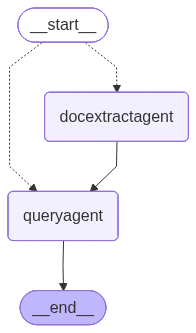

In [14]:
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))